## DMD with Time-Delay Embeddings

[YouTube Video - Time delay embedding for Koopman](https://www.youtube.com/watch?v=K17xYlg_Y_o)  
[Paper - Time-Delay Observables for Koopman: Theory and Applications](https://epubs.siam.org/doi/10.1137/18M1216572)

In [1]:
from pydmd import DMD
from pydmd.plotter import plot_summary
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
import inspect
from sklearn.cluster import k_means
import plotly.graph_objects as go

plt.rcParams['text.usetex'] = True

import warnings
warnings.filterwarnings('ignore')

### Helper Functions

In [2]:
def get_lambda_source(lambda_func):
    try:
        source_lines = inspect.getsource(lambda_func)
        return source_lines.strip()
    except OSError:
        return None

In [3]:
rng = np.random.default_rng()

f1  = lambda x: x/5 * rng.uniform(0.8, 1.2)
f2  = lambda x: x**0.4 * rng.uniform(0.8, 1.2)
f3  = lambda x: np.sqrt(x + rng.uniform(0, 1))
f4  = lambda x: np.log(x + 1 + rng.uniform(0, 2))
f5  = lambda x: np.exp(-rng.uniform(0.005, 0.02) * x)
f6  = lambda x: np.exp(-((x - rng.uniform(40, 60))/rng.uniform(8, 15))**2)
f7  = lambda x: np.sin(rng.uniform(0.05, 0.15) * x)
f8  = lambda x: np.cos(rng.uniform(0.05, 0.15) * x)
f9  = lambda x: np.sin(rng.uniform(0.08, 0.12) * x) * np.exp(-rng.uniform(0.005, 0.02) * x)
f10 = lambda x: x * np.exp(-rng.uniform(0.03, 0.07) * x)

f11 = lambda x: np.log(x + 1 + rng.uniform(0, 1)) * np.sin(rng.uniform(0.15, 0.25) * x)
f12 = lambda x: np.tanh((x - rng.uniform(45, 55)) / rng.uniform(8, 15))
f13 = lambda x: np.sin(x / rng.uniform(4, 6))**2
f14 = lambda x: 1 / (1 + x + rng.uniform(0, 1))
f15 = lambda x: np.exp(-np.sqrt(x + rng.uniform(0, 2)))
f16 = lambda x: np.sin(x / rng.uniform(2, 5)) + rng.uniform(0.005, 0.02) * x
f17 = lambda x: np.cos(x / rng.uniform(3, 5)) * np.exp(-rng.uniform(0.005, 0.02) * x)
f18 = lambda x: np.sin(rng.uniform(0.15, 0.25) * x) * np.sin(rng.uniform(0.03, 0.07) * x)
f19 = lambda x: (
    np.exp(-((x - rng.uniform(25, 35)) / rng.uniform(4, 6))**2) +
    np.exp(-((x - rng.uniform(65, 75)) / rng.uniform(4, 6))**2)
)
f20 = lambda x: np.sinh(rng.uniform(0.008, 0.015) * x)

random_functions = [f1, f2, f3, f4, f5, f6, f7, f8, f9, f10,
             f11, f12, f13, f14, f15, f16, f17, f18, f19, f20]

random_functions = {f'f{i}' : f for i,f in enumerate(random_functions)}

In [4]:
def create_time_series(domain,f1,f2,f3,plot=False):

    x1 = f1(domain)
    x2 = f2(domain)
    x3 = f3(domain)
    
    X = np.vstack([x1,x2,x3]).T

    if plot:
        data = go.Scatter3d(x=X[:,1],y=X[:,2],z=X[:,3],
                    mode='lines')

        layout = go.Layout(width=600,
                           height=600,
                           scene=dict(aspectmode='manual',
                                      aspectratio=dict(x=1, y=1, z=1)))
        
        fig = go.Figure(data=data,layout=layout)
        fig.show()

    return X

In [5]:
def dmd_by_hand(X_full,rank):
    n, m = X_full.T.shape
    
    X = X_full[:,:-1]
    Y = X_full[:,1:]
    
    # SVD of X
    U, S, Vh = np.linalg.svd(X)
    S = np.diag(S)
    
    # r rank of svd of X
    U_r = U[:,:rank]
    S_r = S[:rank,:rank]
    Vh_r = Vh[:rank,:]
    
    # Calculate A_tilde
    U_r_star = U_r.conj().T
    V_r = Vh_r.conj().T
    S_r_inv = np.linalg.inv(S_r)
    
    A_tilde = U_r_star @ Y @ V_r @ S_r_inv
    
    # Eigendecomposition of A_tilde
    eigs, W = np.linalg.eig(A_tilde)
    Λ = np.diag(eigs)
    
    # Koopman Modes & amplitudes
    modes = Y @ V_r @ S_r_inv @ W
    b, _, _, _ = np.linalg.lstsq(modes,X[:,0])

    return eigs, modes, b

### Create Dataset

In [8]:
domain = np.linspace(0,100,1000)

fs = np.random.choice(list(random_functions.keys()),size=3,replace=True)

funcs = [get_lambda_source(random_functions[f]) for f in fs]


X = create_time_series(domain,
                       random_functions[fs[0]],
                       random_functions[fs[1]],
                       random_functions[fs[2]],
                       plot=False)

In [10]:
funcs

['f17 = lambda x: np.cos(x / rng.uniform(3, 5)) * np.exp(-rng.uniform(0.005, 0.02) * x)',
 'f1  = lambda x: x/5 * rng.uniform(0.8, 1.2)',
 'f20 = lambda x: np.sinh(rng.uniform(0.008, 0.015) * x)']

$f_1 = cos(x / \alpha)e^{(-\beta{x})} \textrm{, for }  \alpha \in [3,5], \beta \in [0.005,0.02]$  
$f_2 = \frac{x}{5}\alpha \textrm{, for } \alpha \in [0.8,1.2]$  
$f_3 = sinh(\alpha{x}) \textrm{, for } \alpha \in [0.008,0.015]$  

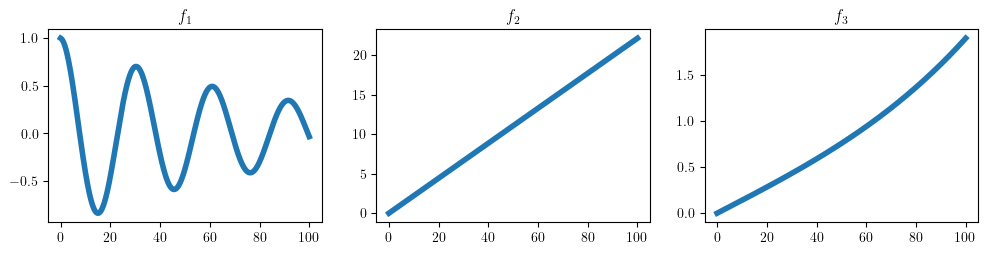

In [13]:
figs, axes = plt.subplots(1,3,figsize=(12,2.5))

for i in range(3):
    axes[i].plot(domain,X[:,i],linewidth=4)
    axes[i].set_title(f'$f_{i+1}$')

plt.show()

### DMD on Raw Dataset

In [14]:
rank = 3

# Execute DMD Using PyDMD Library
dmd = DMD(svd_rank=rank)
dmd.fit(X.T);

# Execute DMD From Scratch
eigs, modes, amplitudes = dmd_by_hand(X.T,rank)

print("DMD Modes (Φ):\n", dmd.modes.shape)
print("DMD Eigenvalues (Λ):\n", dmd.eigs.shape)
print("Reconstructed X:\n", dmd.reconstructed_data.real.shape)

DMD Modes (Φ):
 (3, 3)
DMD Eigenvalues (Λ):
 (3,)
Reconstructed X:
 (3, 1000)


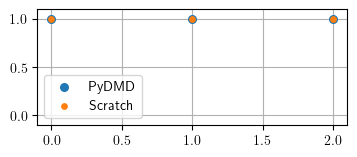

In [15]:
fig, ax = plt.subplots(figsize=(4,1.5))
ax.scatter(np.arange(len(dmd.eigs)),abs(dmd.eigs.real),s=30,label='PyDMD')
ax.scatter(np.arange(len(eigs)),abs(eigs.real),s=15,label='Scratch')
ax.set_ylim([-0.1,1.1])
ax.grid()
ax.set_axisbelow(True)
plt.legend()
plt.show()

In [16]:
eig_matrix = np.vstack([dmd.eigs**i for i in range(X.shape[0])]).T
Y_reconstructed_pydmd = (dmd.modes @ np.diag(dmd.amplitudes) @ eig_matrix).real

eig_matrix = np.vstack([eigs**i for i in range(X.shape[0])]).T
Y_reconstructed_scratch = (modes @ np.diag(amplitudes) @ eig_matrix).real

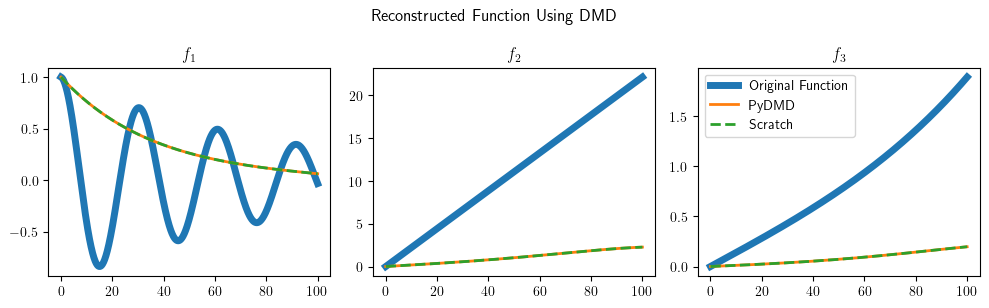

In [26]:
figs, axes = plt.subplots(1,3,figsize=(10,3.1))

for i in range(3):
    axes[i].plot(domain,X[:,i],linewidth=5,label='Original Function')
    axes[i].plot(domain,Y_reconstructed_pydmd[i,:],linewidth=2,label='PyDMD')
    axes[i].plot(domain,Y_reconstructed_scratch[i,:],linewidth=2,linestyle='--',label='Scratch')
    axes[i].set_title(f'$f_{i+1}$')

    if i != 2:
        axes[i].legend = []

plt.suptitle('Reconstructed Function Using DMD')
plt.tight_layout()
plt.legend()
plt.show()

### Apply Time-Delay Embeddings

In [75]:
num_embeddings = 1
n, m = X.shape
X_embedded = np.hstack([X[i:n-num_embeddings+i,:] for i in range(num_embeddings+1)])

X_embedded.shape

(999, 6)

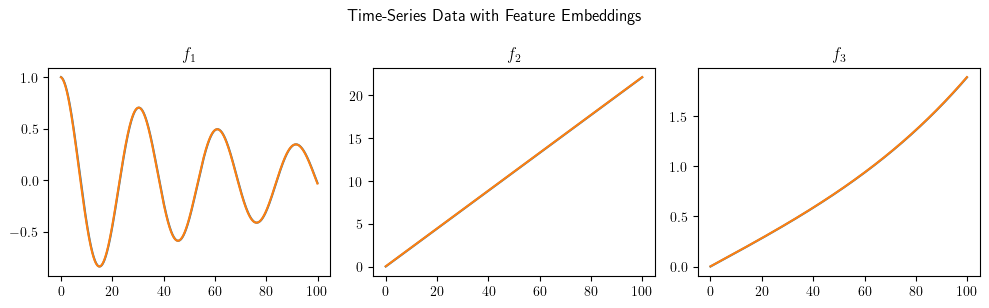

In [76]:
figs, axes = plt.subplots(1,3,figsize=(10,3.1))

for i in range(3):
    axes[i].plot(domain[:n-num_embeddings],X_embedded[:,np.mod(np.arange(X_embedded.shape[1]),3) == i])
    axes[i].set_title(f'$f_{i+1}$')

plt.suptitle('Time-Series Data with Feature Embeddings')
plt.tight_layout()
plt.show()

In [77]:
rank = 6 # X_embedded.shape[1]

# Execute DMD Using PyDMD Library
dmd = DMD(svd_rank=rank)
dmd.fit(X_embedded.T);

# Execute DMD From Scratch
eigs, modes, amplitudes = dmd_by_hand(X_embedded.T,rank)

print("DMD Modes (Φ):\n", dmd.modes.shape)
print("DMD Eigenvalues (Λ):\n", dmd.eigs.shape)
print("Reconstructed X:\n", dmd.reconstructed_data.real.shape)

DMD Modes (Φ):
 (6, 6)
DMD Eigenvalues (Λ):
 (6,)
Reconstructed X:
 (6, 999)


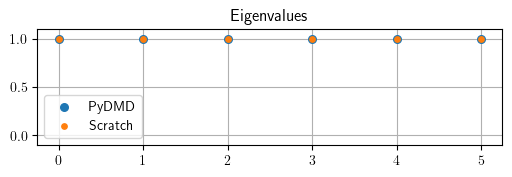

In [83]:
num_eigs = X_embedded.shape[1]
fig, ax = plt.subplots(figsize=(6,1.5))
ax.scatter(np.arange(num_eigs),abs(dmd.eigs.real[:num_eigs]),s=30,label='PyDMD')
ax.scatter(np.arange(num_eigs),abs(eigs.real[:num_eigs]),s=15,label='Scratch')
ax.set_ylim([-0.1,1.1])
ax.grid()
ax.set_axisbelow(True)
plt.legend()
plt.title('Eigenvalues')
plt.show()

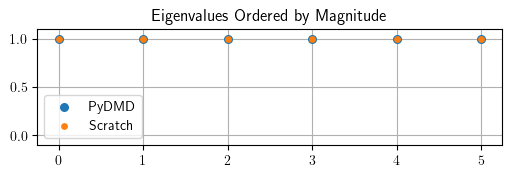

In [84]:
num_eigs = X_embedded.shape[1]

py_eigs = abs(dmd.eigs[np.argsort(abs(dmd.eigs))[::-1][:num_eigs]].real)
reg_eigs = abs(eigs[np.argsort(abs(eigs))[::-1][:num_eigs]].real)

fig, ax = plt.subplots(figsize=(6,1.5))
ax.scatter(np.arange(num_eigs),py_eigs,s=30,label='PyDMD')
ax.scatter(np.arange(num_eigs),reg_eigs,s=15,label='Scratch')
ax.set_ylim([-0.1,1.1])
ax.grid()
ax.set_axisbelow(True)
plt.legend()
plt.title('Eigenvalues Ordered by Magnitude')
plt.show()

In [80]:
eig_matrix = np.vstack([dmd.eigs**i for i in range(X.shape[0])]).T
Y_reconstructed_pydmd = (dmd.modes @ np.diag(dmd.amplitudes) @ eig_matrix).real

eig_matrix = np.vstack([eigs**i for i in range(X.shape[0])]).T
Y_reconstructed_scratch = (modes @ np.diag(amplitudes) @ eig_matrix).real

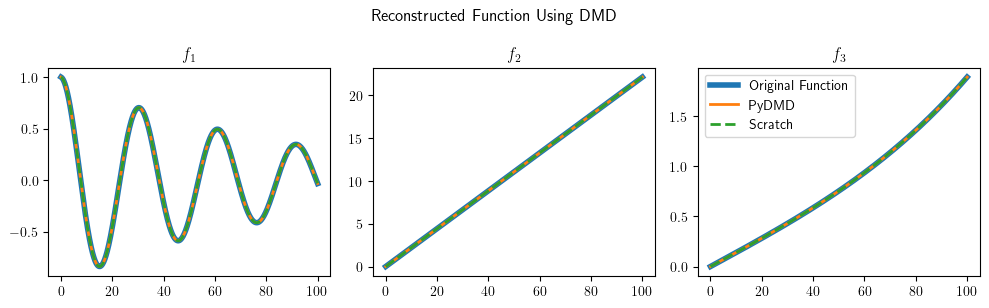

In [81]:
figs, axes = plt.subplots(1,3,figsize=(10,3.1))

for i in range(3):
    axes[i].plot(domain,X[:,i],linewidth=4,label='Original Function')
    axes[i].plot(domain,Y_reconstructed_pydmd[i,:],linewidth=2,label='PyDMD')
    axes[i].plot(domain,Y_reconstructed_scratch[i,:],linewidth=2,linestyle='--',label='Scratch')
    axes[i].set_title(f'$f_{i+1}$')
    if i != 2:
        axes[i].legend = []

plt.suptitle('Reconstructed Function Using DMD')
plt.legend()
plt.tight_layout()
plt.show()

$$
\large{
\left[
  \begin{array}{cccc}
    \big| & \big| &        & \big| \\
    \Phi_{1} & \Phi_{2} & \cdots & \Phi_{r} \\
    \big| & \big| &        & \big|
  \end{array}
\right]
}
\large{
\left[
  \begin{array}{cccc}
    b_1 &        &  \\
        & \ddots &  \\
        &        & b_r
  \end{array}
\right]
}
\large{
\left[
  \begin{array}{cccc}
    \lambda_1 & \cdots & \lambda_1^{m-1} \\
    \vdots    & \ddots & \vdots \\
    \lambda_r & \cdots & \lambda_r^{m-1}
  \end{array}
\right]
}
$$